# Welcome
Cade Mack

This is the notebook for my ITCS 5156 (Applied Machine Learning) project. My problem is Hate Speech Detection and I am using a dataset from the following github repo: https://github.com/t-davidson/hate-speech-and-offensive-language

It should be noted that the repo is associated with the corresponding paper: Thomas Davidson, Dana Warmsley, Michael Macy, and Ingmar Weber. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language."

### Warning

The tweets in the dataset can get pretty vulgar, so discretion is advised.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from nltk.stem.porter import *
import nltk
%matplotlib inline

In [2]:
df = pd.read_csv('data/labeled_data.csv')

In [3]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


The 'class' column is the target variable. It contains 3 different values.

- 0 = HateSpeech
- 1 = Offensive Language
- 2 = Neither

The 'hate_speech', 'offensive_language', and 'neither' columns show how many of the crowdsourced GTers voted each category for the given tweet.

In [5]:
tweets = df.tweet
labels = df['class']

In [80]:
# i = i+1
# i = 935
tweets[i], labels[i], i

("&#128131;&#128131; &amp; if you ain't a ho get up out my trap hooouseee.",
 1,
 959)

(array([0, 1, 2], dtype=int64), array([ 1430, 19190,  4163], dtype=int64))


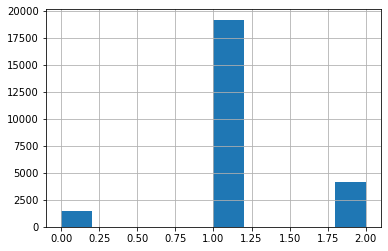

In [57]:
df['class'].hist()
print(np.unique(labels, return_counts=True))

Looks like there are mostly 'offensive_language' tweets in the data. However, there are a fair amount of 'hate_speech' and 'neither' tweets as well.

In [8]:
# Just using NLTKs stopwords
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    
    # Need to do a few things
    # a) Need to remove links (https://blahblah.com)
    # b) Need to remove mentions (@blahblahblah)
    # Trimming excess whitespace
    
    # Removing the emojis (&#125123) could be a good idea, but for now. I'll assume they can help
    
    url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F])|[#])+')
    
    # Whitespace
    new_text = re.sub('\s+', ' ', text)
    # URLs
    new_text = re.sub(url_regex, '', new_text)
    # Mentions
    new_text = re.sub('@[a-zA-Z\-\_0-9]+', '', new_text)
    
    return new_text

def tokenizer(text):
    text = " ".join(re.split("[^a-zA-Z]*", text.lower())).strip()
    return [a for a in text.lower().split()]
    

In [82]:
i = 122
tweets[i]

'"@FloKid88: As long as the Lakers trash from now on, I could careless. And that\'s real.". CC: @BENBALLER hahaha'

In [83]:
preprocess(tweets[i])

'": As long as the Lakers trash from now on, I could careless. And that\'s real.". CC:  hahaha'

In [84]:
tokenizer(preprocess(tweets[i]))

['as',
 'long',
 'as',
 'the',
 'lakers',
 'trash',
 'from',
 'now',
 'on',
 'i',
 'could',
 'careless',
 'and',
 'that',
 's',
 'real',
 'cc',
 'hahaha']

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=tokenizer,
    preprocessor=preprocess,
    stop_words=stopwords,
    use_idf=True,
    decode_error='ignore',
    ngram_range=(1,3),
    max_df=0.75,
    min_df=3
)

In [13]:
tfidf = vectorizer.fit_transform(tweets)

In [14]:
tfidf

<24783x14663 sparse matrix of type '<class 'numpy.float64'>'
	with 219848 stored elements in Compressed Sparse Row format>

In [15]:
tfidf.shape, df['class'].shape

((24783, 14663), (24783,))

In [16]:
X = tfidf.toarray()
T = np.array(df['class'])

In [17]:
X.shape, T.shape

((24783, 14663), (24783,))

In [18]:
X_train, X_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=1)

In [19]:
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((19826, 14663), (4957, 14663), (19826,), (4957,))

In [20]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, t_train)

C:\Anaconda\envs\HateSpeechDetection\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [21]:
print("Train Accuracy: {}".format(model.score(X_train, t_train)))

Train Accuracy: 0.9152627862402906


In [22]:
print("Test Accuracy: {}".format(model.score(X_test, t_test)))
y_test = model.predict(X_test)

Test Accuracy: 0.8662497478313496


In [23]:
report = classification_report(t_test, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.54      0.42       296
           1       0.96      0.87      0.92      3853
           2       0.77      0.94      0.85       808

    accuracy                           0.87      4957
   macro avg       0.69      0.79      0.73      4957
weighted avg       0.90      0.87      0.88      4957



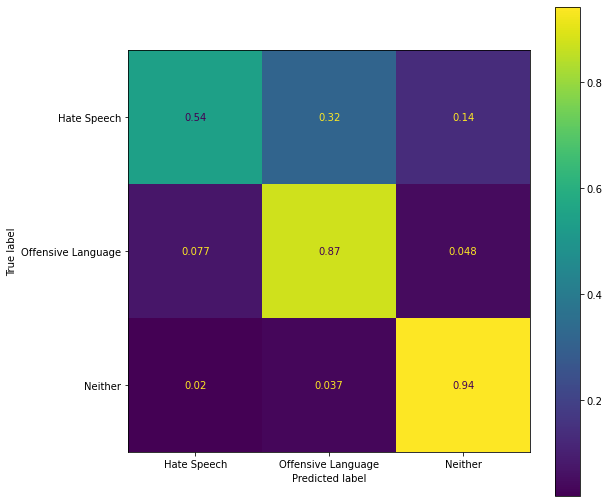

In [24]:
cm = confusion_matrix(t_test, y_test, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['Hate Speech', 'Offensive Language', 'Neither'])
fig, ax = plt.subplots(figsize=(9, 9))
disp.plot(ax=ax)

In [25]:
pos_tags = []
for t in tweets:
    tokens = tokenizer(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    pos_tags.append(" ".join(tag_list))

C:\Anaconda\envs\HateSpeechDetection\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [26]:
pos_tags[0]

'NN IN DT NN PRP VBP JJ NN IN VBG RP PRP$ NN NN IN DT NN PRP MD RB VB DT NN RP'

In [27]:
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    ngram_range=(1,3),
    decode_error='ignore',
    min_df=3,
    max_df=0.75
)

In [28]:
pos_features = pos_vectorizer.fit_transform(pos_tags)

In [29]:
pos_features = pos_features.toarray()
word_features = tfidf.toarray()

In [30]:
pos_features.shape, word_features.shape

((24783, 5111), (24783, 14663))

In [31]:
X = np.concatenate((pos_features, word_features), 1)
X.shape

(24783, 19774)

In [32]:
X_train, X_test, t_train, t_test = train_test_split(X, T, test_size=0.2, random_state=1)

In [33]:
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((19826, 19774), (4957, 19774), (19826,), (4957,))

In [34]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, t_train)

C:\Anaconda\envs\HateSpeechDetection\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(class_weight='balanced')

In [35]:
print("Train Accuracy: {}".format(model.score(X_train, t_train)))

Train Accuracy: 0.9334207606173711


In [36]:
print("Test Accuracy: {}".format(model.score(X_test, t_test)))
y_test = model.predict(X_test)

Test Accuracy: 0.8700827113173291


In [37]:
report = classification_report(t_test, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.47      0.40       296
           1       0.96      0.89      0.92      3853
           2       0.77      0.94      0.84       808

    accuracy                           0.87      4957
   macro avg       0.69      0.76      0.72      4957
weighted avg       0.89      0.87      0.88      4957



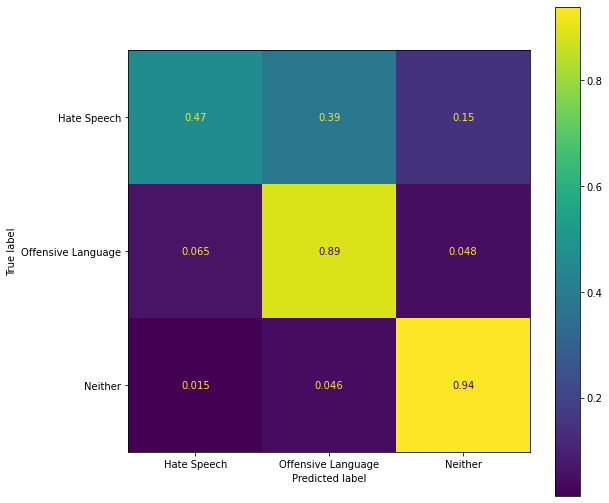

In [38]:
cm = confusion_matrix(t_test, y_test, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['Hate Speech', 'Offensive Language', 'Neither'])
fig, ax = plt.subplots(figsize=(9, 9))
disp.plot(ax=ax)

In [47]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('reduction', SelectFromModel(LogisticRegression(class_weight='balanced', C=0.05))),
    ('model', LogisticRegression(class_weight='balanced',penalty='l2'))
])

In [42]:
pipe.fit(X_train, t_train)

C:\Anaconda\envs\HateSpeechDetection\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('reduction',
                 SelectFromModel(estimator=LogisticRegression(C=0.05,
                                                              class_weight='balanced'))),
                ('model', LogisticRegression(class_weight='balanced'))])

In [43]:
print("Train Accuracy: {}".format(pipe.score(X_train, t_train)))

Train Accuracy: 0.9163220014122869


In [44]:
print("Test Accuracy: {}".format(pipe.score(X_test, t_test)))
y_test = model.predict(X_test)

Test Accuracy: 0.8648376033891466


In [45]:
report = classification_report(t_test, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.47      0.40       296
           1       0.96      0.89      0.92      3853
           2       0.77      0.94      0.84       808

    accuracy                           0.87      4957
   macro avg       0.69      0.76      0.72      4957
weighted avg       0.89      0.87      0.88      4957



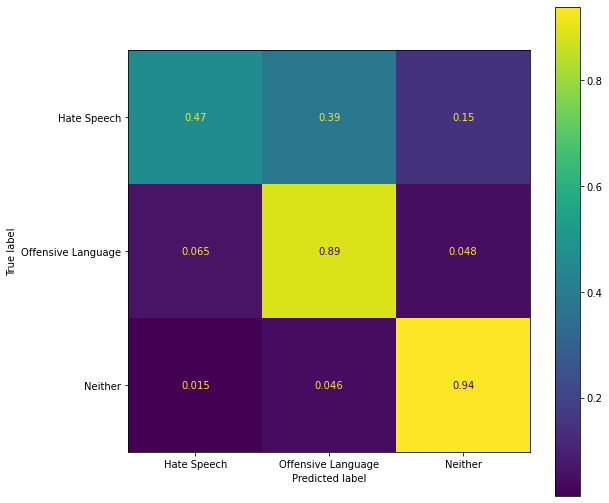

In [46]:
cm = confusion_matrix(t_test, y_test, normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=['Hate Speech', 'Offensive Language', 'Neither'])
fig, ax = plt.subplots(figsize=(9, 9))
disp.plot(ax=ax)